In [15]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
sys.path.append(str(Path.cwd().parent))

In [16]:
# Directory containing pickle files
directory = Path("../results/regression_std/quantitative") # NOTE THE FILE PATH!!!

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [17]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)

print(df.shape)

(111633, 25)


In [18]:
# Prepare the dataframe
df = df[df['k'] != 1]
df['is_auto'] = pd.Series(df['k'] == 'auto', dtype=bool)
df['is_all'] = pd.Series(df['k'] == 'all', dtype=bool)
df.loc[df['is_all'], 'k'] = df['n_samples']
df.loc[df['k'].isna(), 'k'] = 'NA'
df.loc[df['prox_method'].isna(), 'prox_method'] = 'NA'

In [19]:
df['Method'] = df['method']
df.loc[df['Method'] == 'qrf', 'Method'] = 'QRF'

df.loc[df['Method'] == 'zrf', 'Method'] = 'OOB Int.' # Perhaps change this name

df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'rfgap'), 'Method'] = 'RF-FIRE'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'original'), 'Method'] = 'RF-FIRE (Original)'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'oob'), 'Method'] = 'RF-FIRE (OOB)'

/tmp/ipykernel_1904325/900224728.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]


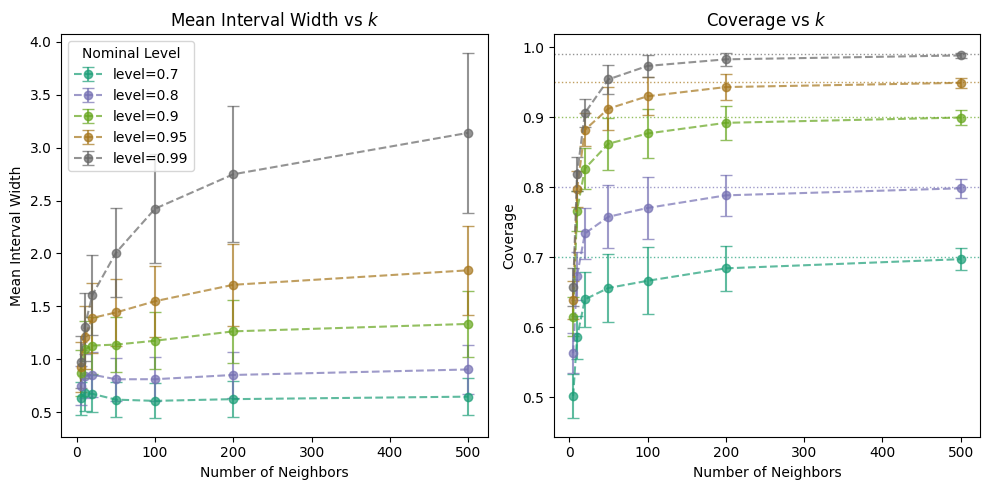

In [ ]:


# Compute mean and std for width_mean and coverage for each group
pivot_df = (
    df[
        (df['k'].isin([5, 10, 20, 50, 100, 200, 500])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])
    .agg(
        width_mean_mean=('width_mean', 'mean'),
        width_mean_std=('width_mean', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std')
    )
    .reset_index()
)


# Use a perceptually uniform colormap for levels
unique_levels = sorted(pivot_df[pivot_df['prox_method'] == 'rfgap']['level'].unique())
level_palette = dict(zip(
    unique_levels,
    [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]
))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Only plot 'rfgap' prox_method for mean interval width
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k'])
    ax1.errorbar(
        subgrp['k'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker='o',
        color=level_palette[level],
        alpha = 0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$')
ax1.legend(title='Nominal Level')

# Only plot 'rfgap' prox_method for coverage
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$')

plt.tight_layout()
plt.show()


/tmp/ipykernel_1904325/3137093588.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]


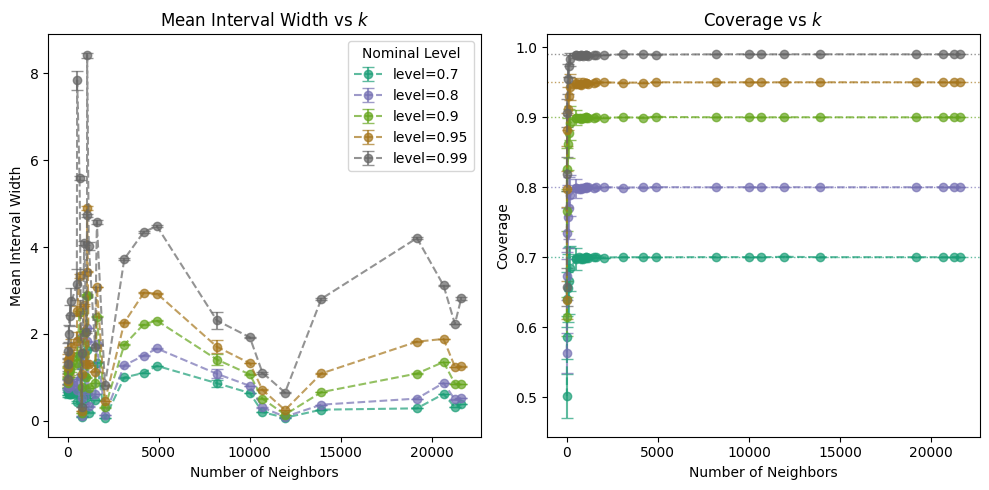

In [42]:


# Compute mean and std for width_mean and coverage for each group
pivot_df = (
    df[
        (~df['k'].isin(['auto', 'NA'])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])
    .agg(
        width_mean_mean=('width_mean', 'mean'),
        width_mean_std=('width_mean', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std')
    )
    .reset_index()
)


# Use a perceptually uniform colormap for levels
unique_levels = sorted(pivot_df[pivot_df['prox_method'] == 'rfgap']['level'].unique())
level_palette = dict(zip(
    unique_levels,
    [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]
))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Only plot 'rfgap' prox_method for mean interval width
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k'])
    ax1.errorbar(
        subgrp['k'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker='o',
        color=level_palette[level],
        alpha = 0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$')
ax1.legend(title='Nominal Level')

# Only plot 'rfgap' prox_method for coverage
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$')

plt.tight_layout()
plt.show()


In [46]:
200 / 8200

0.024390243902439025

In [44]:
df.n_samples.unique().mean()

8198.26923076923

In [ ]:
### Coverage typically met with about 20% of samples

In [28]:
# Convert 'k' to numeric, coercing non-numeric (e.g., "auto") to NaN
df['k_numeric'] = pd.to_numeric(df['k'], errors='coerce')

# Compute percentage of k relative to n_samples
df['k_pct_n_samples'] = (df['k_numeric'] / df['n_samples']) * 100

# Compute reference mean_width for each unique n_samples where k == n_samples
reference_widths = df[df['k_numeric'] == df['n_samples']].groupby('n_samples')['width_mean_test'].mean()

# Map the reference mean width back to the original DataFrame based on n_samples
df['ref_width'] = df['n_samples'].map(reference_widths)

# Compute width_mean_test as a percentage of reference width
df['width_pct_of_ref'] = (df['width_mean_test'] / df['ref_width']) * 100

In [30]:
# Group by 'level', 'method', and original 'k' (not the numeric version)
grouped_detailed = df.groupby(['level', 'Method', 'k'])[['k_pct_n_samples', 'width_pct_of_ref']].mean().reset_index()

In [35]:
grouped_detailed

,level,Method,k,k_pct_n_samples,width_pct_of_ref
0,0.70,OOB Int.,NA,NaN,40.332298
1,0.70,QRF,NA,NaN,47.191738
2,0.70,RF-FIRE,5,0.262838,36.891508
3,0.70,RF-FIRE,10,0.531122,40.141393
4,0.70,RF-FIRE,20,1.088126,41.350496
...,...,...,...,...,...
465,0.99,RF-FIRE (Original),11934,100.000000,270.909874
466,0.99,RF-FIRE (Original),13932,100.000000,270.844491
467,0.99,RF-FIRE (Original),19178,100.000000,265.804850
468,0.99,RF-FIRE (Original),20640,100.000000,198.665155


In [38]:
grouped_detailed[grouped_detailed['Method'] == 'RF-FIRE'].groupby(['level', 'k_pct_n_samples'])['width_pct_of_ref'].mean()

level  k_pct_n_samples
0.70   0.262838            36.891508
       0.531122            40.141393
       1.088126            41.350496
       2.749112            40.763004
       5.517666            39.126057
       11.114010           38.803443
       27.785024           39.415999
       100.000000          38.562984
0.80   0.262838            43.863864
       0.531122            49.354043
       1.088126            52.470370
       2.749112            53.381901
       5.517666            52.422243
       11.114010           53.101430
       27.785024           54.935204
       100.000000          54.603129
0.90   0.263739            50.836219
       0.531122            63.845786
       1.088126            69.112847
       2.749112            74.543475
       5.517666            75.660438
       11.114010           78.852756
       27.785024           82.603042
       100.000000          83.653725
0.95   0.265561            54.322397
       0.536585            71.091658
       1.099645

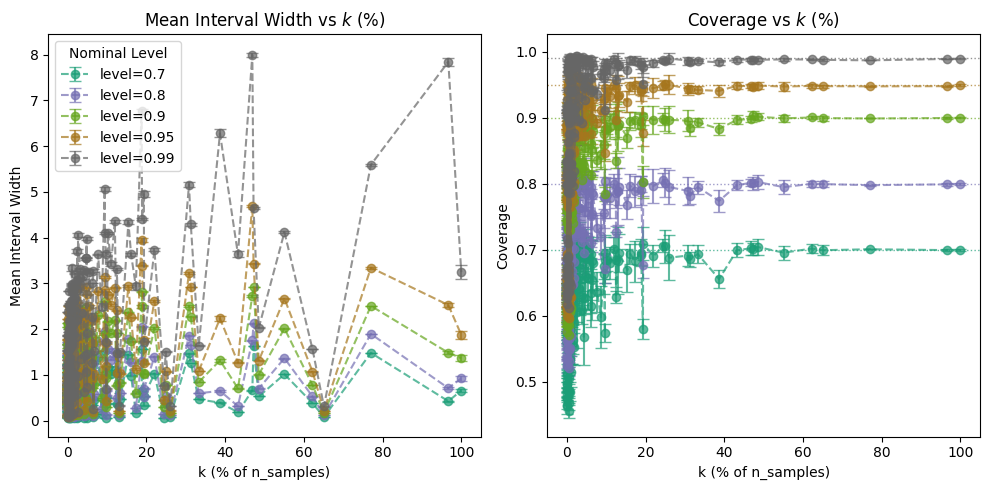

In [ ]:
# Compute k as a percentage of n_samples for each row in df
# df['k_pct'] = df['k'] / df['n_samples'] * 100

# Recompute pivot_df using k_pct
pivot_df_pct = (
    df[
        (~df['k'].isin(['NA', 'auto'])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .assign(k_pct=lambda d: d['k'] / d['n_samples'] * 100)
    .groupby(['prox_method', 'level', 'k_pct'])
    .agg(
        width_mean_mean=('width_mean', 'mean'),
        width_mean_std=('width_mean', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std')
    )
    .reset_index()
)

# Use the same color palette as before
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

for level, subgrp in pivot_df_pct[pivot_df_pct['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k_pct'])
    ax1.errorbar(
        subgrp['k_pct'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('k (% of n_samples)')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$ (%)')
ax1.legend(title='Nominal Level')

for level, subgrp in pivot_df_pct[pivot_df_pct['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k_pct'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker='o',
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('k (% of n_samples)')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$ (%)')

plt.tight_layout()
plt.show()


In [ ]:
pivot_df_pct_rounded = pivot_df_pct.copy()
pivot_df_pct_rounded['k_pct'] = (pivot_df_pct_rounded['k_pct'] / 20).round() * 20

# Add is_covered column
pivot_df_pct_rounded['is_covered'] = (
    (pivot_df_pct_rounded['coverage_mean'] - pivot_df_pct_rounded['coverage_std'] <= pivot_df_pct_rounded['level']) &
    (pivot_df_pct_rounded['coverage_mean'] + pivot_df_pct_rounded['coverage_std'] >= pivot_df_pct_rounded['level'])
)

pivot_df_pct_rounded[pivot_df_pct_rounded['prox_method'] == 'rfgap']

,prox_method,level,k_pct,width_mean_mean,width_mean_std,coverage_mean,coverage_std,is_covered
775,rfgap,0.70,0.0,1.116665,0.038034,0.495569,0.004401,False
776,rfgap,0.70,0.0,1.231743,0.009363,0.479609,0.003141,False
777,rfgap,0.70,0.0,0.353439,0.004003,0.475359,0.002982,False
778,rfgap,0.70,0.0,0.300043,0.003744,0.513619,0.003333,False
779,rfgap,0.70,0.0,0.531249,0.005156,0.487611,0.002957,False
...,...,...,...,...,...,...,...,...
1631,rfgap,0.99,60.0,1.564118,0.096103,0.988078,0.001465,False
1632,rfgap,0.99,60.0,0.311353,0.020051,0.987523,0.001533,False
1633,rfgap,0.99,80.0,5.591979,0.266270,0.986784,0.000000,False
1634,rfgap,0.99,100.0,7.840640,1.175642,0.988920,0.000000,False


In [ ]:
pivot_df_pct_rounded.groupby(['level', 'k_pct'])['is_covered'].mean()

level  k_pct
0.70   0.0      0.299242
       20.0     0.861111
       40.0     0.750000
       60.0     1.000000
       80.0     0.000000
       100.0    1.000000
0.80   0.0      0.321970
       20.0     0.777778
       40.0     0.750000
       60.0     1.000000
       80.0     0.000000
       100.0    1.000000
0.90   0.0      0.295455
       20.0     0.777778
       40.0     0.750000
       60.0     1.000000
       80.0     0.000000
       100.0    1.000000
0.95   0.0      0.232824
       20.0     0.722222
       40.0     0.625000
       60.0     0.666667
       80.0     0.000000
       100.0    0.500000
0.99   0.0      0.133588
       20.0     0.388889
       40.0     0.500000
       60.0     0.333333
       80.0     0.000000
       100.0    0.500000
Name: is_covered, dtype: float64

/tmp/ipykernel_1904325/600518483.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]


NameError: name 'prox_styles' is not defined

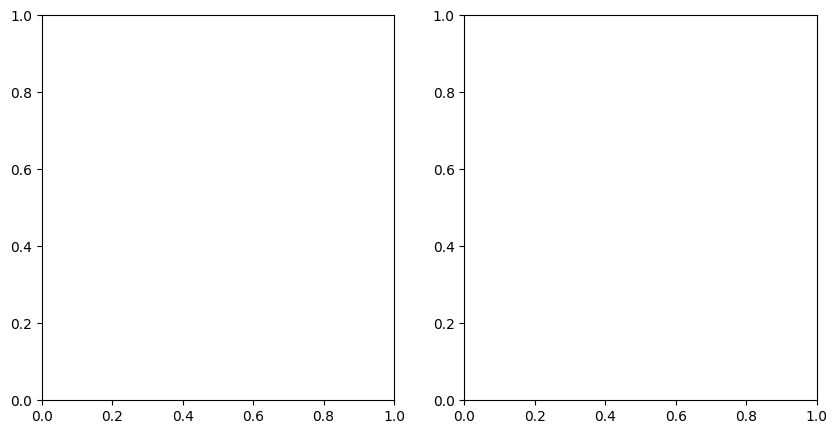

In [ ]:
import matplotlib.cm as cm

# Use a perceptually uniform colormap for levels
unique_levels = sorted(pivot_df[pivot_df['prox_method'] == 'rfgap']['level'].unique())
level_palette = dict(zip(
    unique_levels,
    [cm.get_cmap('Dark2')(i / (len(unique_levels) - 1)) for i in range(len(unique_levels))]
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Only plot 'rfgap' prox_method for mean interval width
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    n = len(subgrp['k'])
    ax1.errorbar(
        subgrp['k'],
        subgrp['width_mean_mean'],
        yerr=subgrp['width_mean_std'] / np.sqrt(n),
        marker=prox_styles.get('rfgap', 'o'),
        color=level_palette[level],
        alpha = 0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )

ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Mean Interval Width')
ax1.set_title(r'Mean Interval Width vs $k$')
ax1.legend(title='Nominal Level')

# Only plot 'rfgap' prox_method for coverage
for level, subgrp in pivot_df[pivot_df['prox_method'] == 'rfgap'].groupby('level'):
    ax2.errorbar(
        subgrp['k'],
        subgrp['coverage_mean'],
        yerr=subgrp['coverage_std'],
        marker=prox_styles.get('rfgap', 'o'),
        color=level_palette[level],
        alpha=0.7,
        label=f"level={level}",
        linestyle='--',
        capsize=4
    )
    ax2.axhline(level, color=level_palette[level], linestyle=':', linewidth=1, alpha=0.7)

ax2.set_xlabel('Number of Neighbors')
ax2.set_ylabel('Coverage')
ax2.set_title(r'Coverage vs $k$')

plt.tight_layout()
plt.show()


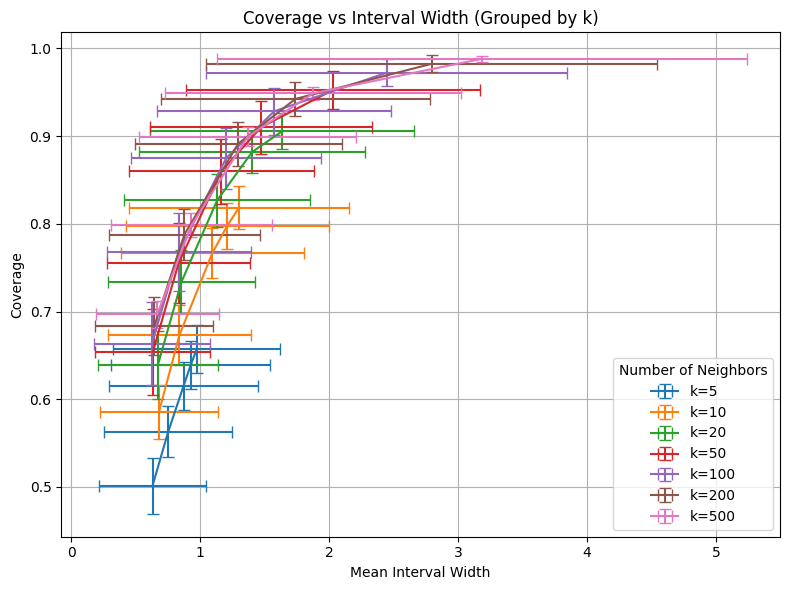

In [ ]:
import matplotlib.pyplot as plt

# Filter just the 'rfgap' method
rfgap_df = pivot_df[pivot_df['prox_method'] == 'rfgap']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Group by k (number of neighbors)
for k, subgrp in rfgap_df.groupby('k'):
    ax.errorbar(
        subgrp['width_mean_mean'],
        subgrp['coverage_mean'],
        xerr=subgrp['width_mean_std'],
        yerr=subgrp['coverage_std'],
        # marker=prox_styles.get('rfgap', 'o'),
        linestyle='-',
        label=f'k={k}',
        capsize=4
    )

ax.set_xlabel('Mean Interval Width')
ax.set_ylabel('Coverage')
ax.set_title('Coverage vs Interval Width (Grouped by k)')
ax.legend(title='Number of Neighbors')
ax.grid(True)
plt.tight_layout()
plt.show()


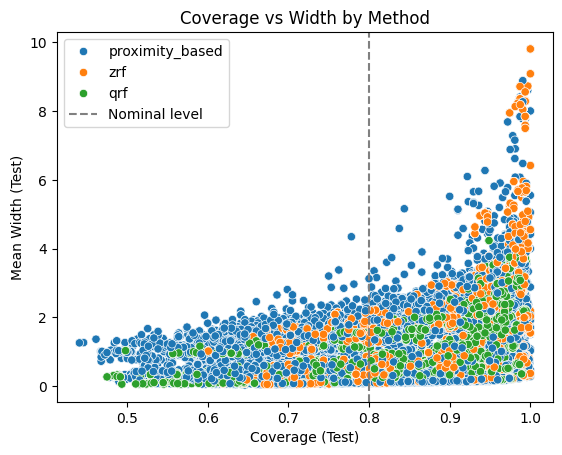

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='coverage_test', y='width_mean_test', hue='method')
plt.axvline(df['level'].iloc[0], color='gray', linestyle='--', label='Nominal level')
plt.xlabel('Coverage (Test)')
plt.ylabel('Mean Width (Test)')
plt.title('Coverage vs Width by Method')
plt.legend()
plt.show()


/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


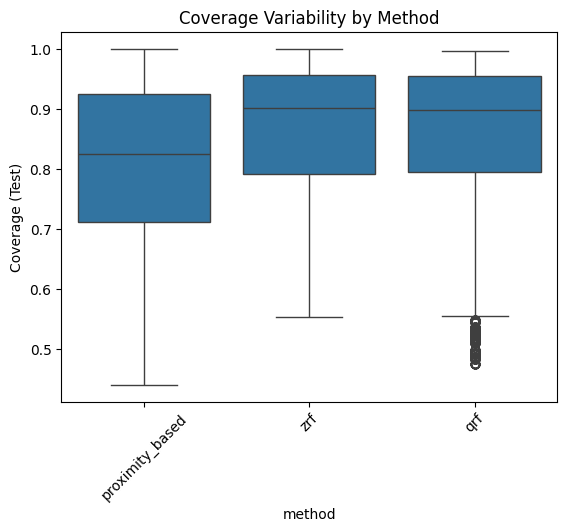

In [ ]:
sns.boxplot(data=df, x='method', y='coverage_test')
plt.title('Coverage Variability by Method')
plt.ylabel('Coverage (Test)')
plt.xticks(rotation=45)
plt.show()


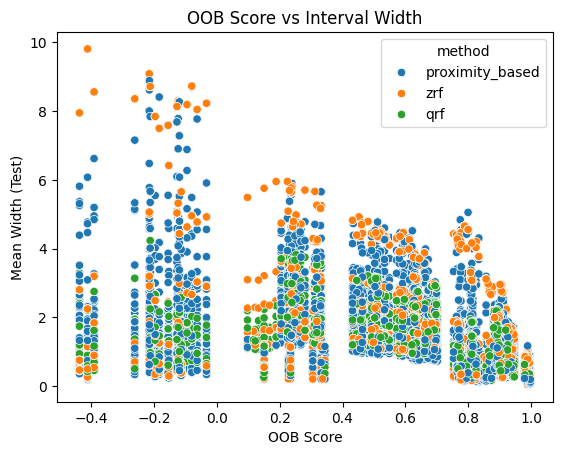

In [ ]:
sns.scatterplot(data=df, x='oob_score_', y='width_mean_test', hue='method')
plt.xlabel('OOB Score')
plt.ylabel('Mean Width (Test)')
plt.title('OOB Score vs Interval Width')
plt.show()


/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


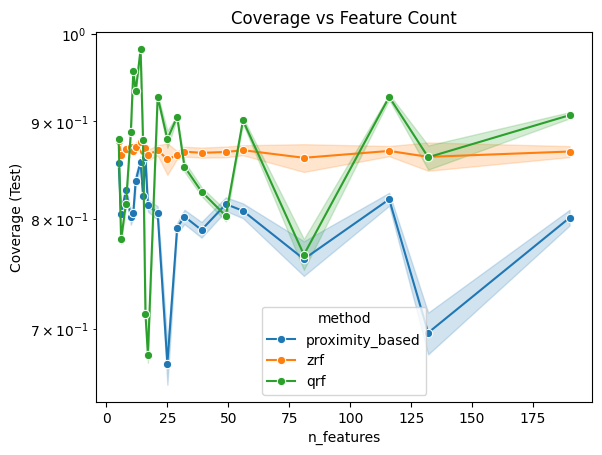

/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


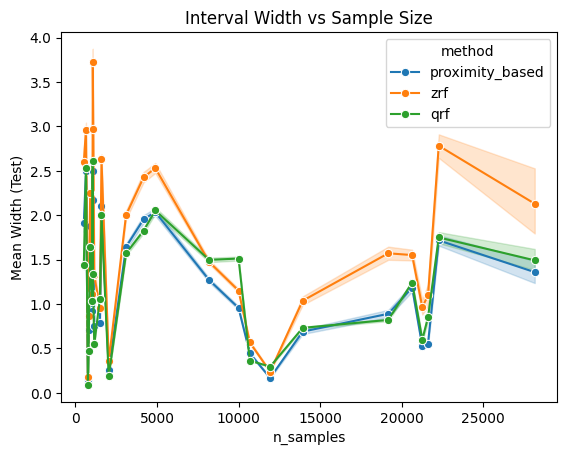

In [ ]:
sns.lineplot(data=df, x='n_features', y='coverage_test', hue='method', marker='o')
plt.yscale('log')
plt.title('Coverage vs Feature Count')
plt.ylabel('Coverage (Test)')
plt.show()

sns.lineplot(data=df, x='n_samples', y='width_mean_test', hue='method', marker='o')
plt.title('Interval Width vs Sample Size')
plt.ylabel('Mean Width (Test)')
plt.show()


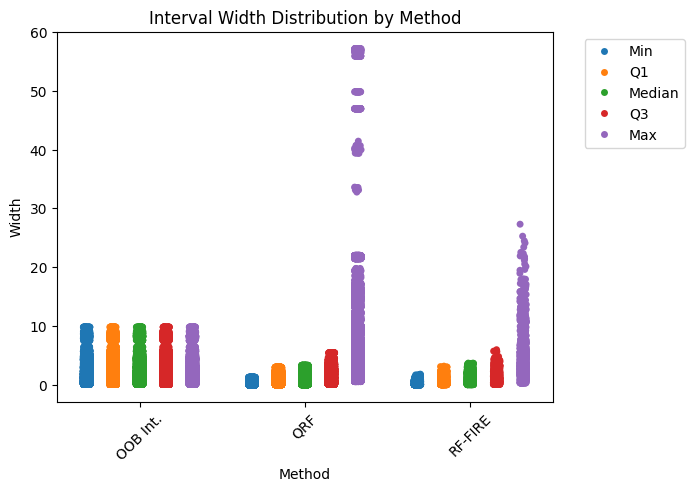

In [ ]:
# Keep something like this as well.
# May need to do some grouping by k!!!

# WAS WORKING WITHOUT K
width_quantiles = df[['Method', 'k', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]
width_quantiles = width_quantiles.loc[width_quantiles['k'].isin(['NA', 'auto'])]

width_quantiles = width_quantiles[['Method', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]



# width_quantiles = df[['Method', 'width_min_test', 'width_q1_test', 'width_median_test', 'width_q3_test', 'width_max_test']]
width_quantiles = width_quantiles[width_quantiles['Method'].isin(['QRF', 'OOB Int.', 'RF-FIRE'])]
long_df = width_quantiles.melt(id_vars='Method', var_name='quantile', value_name='Width')

# Rename quantile values for prettier legend
quantile_map = {
    'width_min': 'Min',
    'width_q1': 'Q1',
    'width_median': 'Median',
    'width_q3': 'Q3',
    'width_max': 'Max'
}
long_df['quantile'] = long_df['quantile'].map(quantile_map)

sns.stripplot(data=long_df, x='Method', y='Width', hue='quantile', dodge = True)
# plt.yscale('log')
plt.title('Interval Width Distribution by Method')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


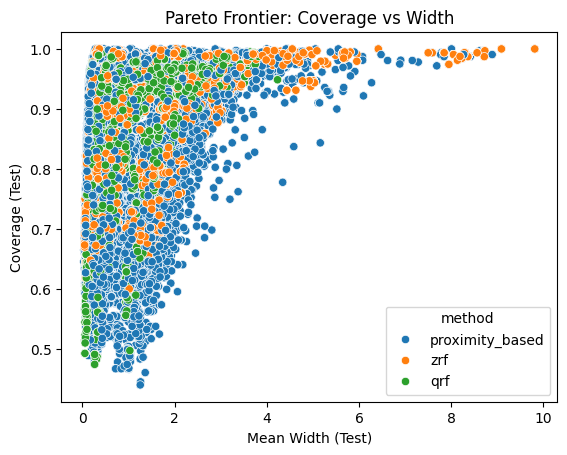

In [ ]:
sns.scatterplot(data=df, x='width_mean_test', y='coverage_test', hue='method')
plt.xlabel('Mean Width (Test)')
plt.ylabel('Coverage (Test)')
plt.title('Pareto Frontier: Coverage vs Width')
plt.show()


In [ ]:
def balanced_interval_score(width, coverage, target_coverage=0.95, penalty_weight=1.0):
    """
    Compute the Balanced Interval Score (BIS).
    
    Parameters:
    - width: float or array-like, the width(s) of the interval(s)
    - coverage: float or array-like, the empirical coverage rate(s) (e.g., proportion of times true value in interval)
    - target_coverage: float, desired coverage level (e.g., 0.95)
    - penalty_weight: float, how heavily to penalize deviations from target coverage
    
    Returns:
    - BIS value(s): float or array-like
    """
    import numpy as np
    
    width = np.asarray(width)
    coverage = np.asarray(coverage)
    penalty = 1 + penalty_weight * np.abs(coverage - target_coverage)
    bis = 1.0 / (width * penalty)
    
    return bis


In [ ]:
widths = df['width_median']
coverages = df['coverage']
levels = df['level']
df['bis'] = balanced_interval_score(df['width_mean'], df['coverage'], df['level'],
                                    penalty_weight=1)

<Axes: xlabel='Method', ylabel='bis'>

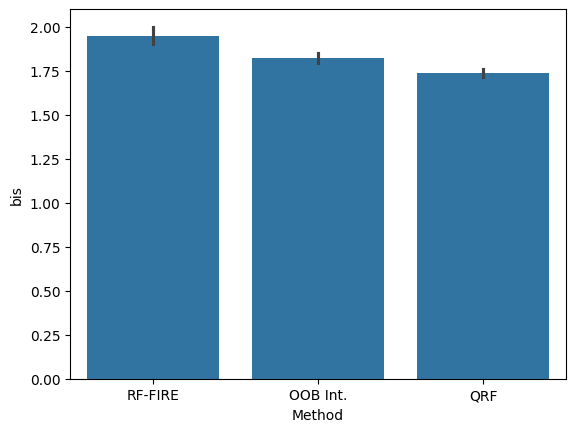

In [ ]:
# Keep something like this.
sns.barplot(data=df[df['Method'].isin(['RF-FIRE', 'QRF', 'OOB Int.'])], x='Method', y='bis')

In [ ]:
# Filter methods of interest
methods = ['RF-FIRE', 'QRF', 'OOB Int.']
filtered_df = df[df['Method'].isin(methods)]

# Compute mean and standard error
summary = (
    filtered_df.groupby('Method')['bis']
    .agg(['mean', 'std', 'count'])
    .assign(sem=lambda d: d['std'] / np.sqrt(d['count']))
    .reset_index()
)

# Sort descending by mean
summary = summary.sort_values(by='mean', ascending=False).reset_index(drop=True)

# Identify the top method for bolding
top_method = summary.loc[0, 'Method']

# Generate LaTeX rows with bolding
latex_rows = []
for _, row in summary.iterrows():
    method = row['Method']
    mean = f"{row['mean']:.3f}"
    sem = f"{row['sem']:.3f}"
    line = f"{method} & {mean} $\\pm$ {sem} \\\\"
    if method == top_method:
        line = r"\textbf{" + line + "}"
    latex_rows.append(line)

# Construct LaTeX table
latex_table = r"""\begin{tabular}{l c}
\toprule
Method & bis ($\pm$ SEM) \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabular}
"""

print(latex_table)


\begin{tabular}{l c}
\toprule
Method & bis ($\pm$ SEM) \\
\midrule
\textbf{RF-FIRE & 1.949 $\pm$ 0.026 \\}
OOB Int. & 1.822 $\pm$ 0.015 \\
QRF & 1.736 $\pm$ 0.011 \\
\bottomrule
\end{tabular}



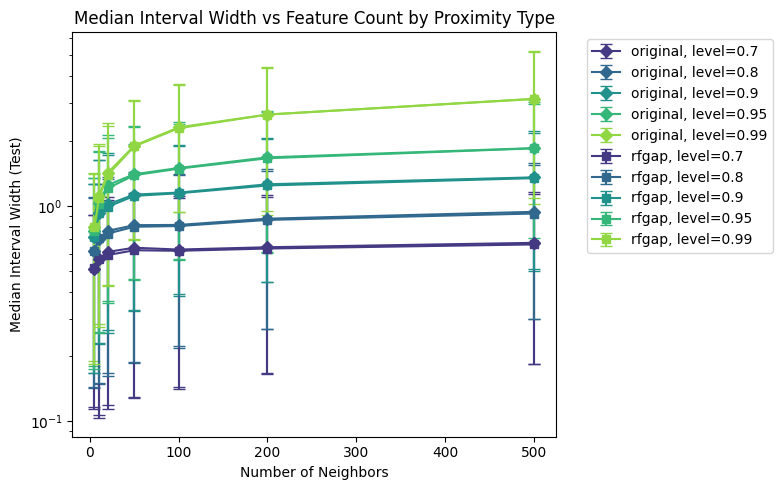

In [ ]:
pivot_df = (
    df[
        (df['k'].isin([5, 10, 20, 50, 100, 200, 500])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])['width_median_test']
    .agg(['mean', 'std'])
    .reset_index()
)

prox_styles = {'oob': 'o', 'rfgap': 's', 'original': 'D'}
levels = sorted(pivot_df['level'].unique())
level_palette = dict(zip(levels, sns.color_palette("viridis", len(levels))))

fig, ax = plt.subplots(figsize=(8, 5))
for prox_method, group in pivot_df.groupby('prox_method'):
    for level, subgrp in group.groupby('level'):
        ax.errorbar(
            subgrp['k'],
            subgrp['mean'],
            yerr=subgrp['std'],
            marker=prox_styles.get(prox_method, 'o'),
            color=level_palette[level],
            label=f"{prox_method}, level={level}",
            linestyle='-',
            capsize=4
        )

ax.set_title('Median Interval Width vs Feature Count by Proximity Type')
ax.set_ylabel('Median Interval Width (Test)')
ax.set_xlabel('Number of Neighbors')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_yscale('log')
fig.tight_layout()
plt.show()
